## TP3 : Logistic regression

The purpose of this tutorial is to implement and use the Logistic Regression for binary classification. We will apply this
method to the problem of handwritten characters to learn how to
distinguish two numbers (here 5 and 6).

In [1]:
from pylab import *
#import numpy as np
#import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as la
import pandas as pd 
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import sklearn as sk
from sklearn.linear_model import LogisticRegression

## 1. Logistic regression, IRLS algorithm.

### Preliminary question: the algorithm

#### Have a look at the function `regression_logistique.m` and locate the main steps of the algorithm you have been taught (see course).
You can comment the code in the cell below.

In [2]:
def regression_logistique(X,t,Nitermax=20,eps_conv=1e-3):
    '''Entrees :
    X = [ones(N_train,1) x_train];
    t = class_train 
    Nitermax = nombre maximale d'itérations (20 par défaut)
    eps_conv = critère de convergence sur norm(w-w_old)/norm(w) ; 
    eps_conv=1e-3 par défaut
    
    Sorties : 
    w : vecteur des coefficients de régression logistique
   Niter : nombre d'itérations utilisées effectivement
   
   Fonction de régression logistique pour la classification binaire.
   
   Utilisation :
       Nitermax = 50
       eps_conv = 1e-4
       [w,Niter] = regression_logistique(X,t,Nitermax,eps_conv)
    '''
    N_train = X.shape[0]

    #initialisation : 1 pas de l'algorithme IRLS
    w = np.zeros((X.shape[1],)) #Initialisation des pas à 0
    w_old = w #stockage des anciens poids
    y = 1/2*np.ones((N_train,))#initialisation de la prédiction avec un seuil de 1/2 
    R = np.diag(y*(1-y))   # diag(y_n(1-y_n)) initialisation de la reweighted matrice
    z = X.dot(w_old)-la.inv(R).dot(y-t)#Calcul de la combinaison linéaire des features
    w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z) # mise à jour des poids en utilisant la formule de Newton Raphson

    # boucle appliquant l'algorithme de Newton-Raphson
    Niter = 1
    while ( (la.norm(w-w_old)/la.norm(w)>eps_conv) & (Niter<Nitermax) ):
        Niter = Niter+1
        y = 1/(1+np.exp(-X.dot(w))) #calcul de la proba en utilisant la fonction logistique
        R = np.diag(y*(1-y))  #création de la reweihted matrice qui donne plus de poids aux points difficiles à classer
        w_old = w 
        z = X.dot(w_old)-la.inv(R).dot(y-t) #calcul de z avec les poids mis à jour
        w = la.inv(X.T.dot(R).dot(X)).dot(X.T).dot(R).dot(z) # mise à jour des poids en utilisant la formule de Newtn Raphson
         
    return w, Niter


### Reading & preparing synthetic data

Load the training and test data sets `synth_train.txt`
and `synth_test.txt`. The targets t belong to {1,2} and the features  
x belong to R^2. 

We have 100 training samples and 200 test samples

* the 1st column contains the label of each sample, 
* columns 2 and 3 contain the coordinate of each point.

In [3]:
# Training set
synth_train = np.loadtxt('synth_train.txt') 
class_train = synth_train[:,0]
class_train_1 = np.where(synth_train[:,0]==1)[0]
class_train_2 = np.where(synth_train[:,0]==2)[0]
x_train = synth_train[:,1:]
N_train = np.size(x_train,axis=0)

# Test set
synth_test = np.loadtxt('synth_test.txt')
class_test = synth_test[:,0]
class_test_1 = np.where(synth_test[:,0]==1)[0]
class_test_2 = np.where(synth_test[:,0]==2)[0]
x_test = synth_test[:,1:]
N_test = np.size(x_test,axis=0)


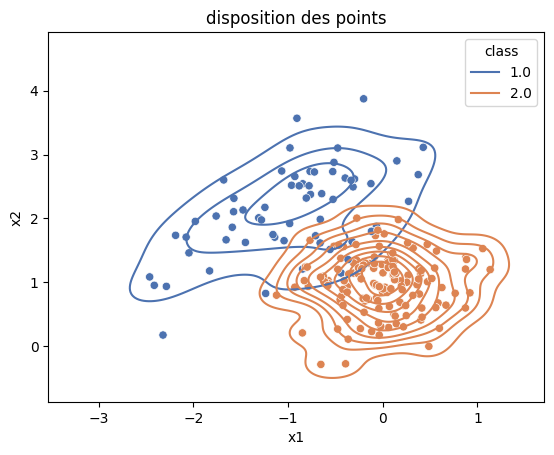

In [4]:
synth_train_pd=pd.DataFrame(synth_train,columns=['class','x1','x2'])
synth_test_pd= pd.DataFrame(synth_test,columns=['class','x1','x2'])
sns.scatterplot(synth_test_pd,x="x1",y="x2",hue="class",palette="deep")
plt.title("disposition des points")
sns.kdeplot(synth_test_pd,x="x1",y="x2",hue="class",palette="deep")
plt.show()

**Commentaire :**   
On voit que notre dataset est visuellement séparable mais que certains points poseront problème. En traçant des gaussiennes en utilisant la kernel density estimation on voit que les distibutions se recouvrent ce qui suggère des points compliqués à classer.

### Preparing features for logistic regression (binary classification)
First, we prepare the feature matrix and the target vector associated to 
the training and test sets:


In [5]:
X = np.hstack((np.ones((N_train,1)),x_train))
t = 2-class_train   # 0 if class=2, 1 if class=1
pd_train=pd.DataFrame({"x1": X[:,1],"x2":X[:,2],"class": t})

X_test = np.hstack((np.ones((N_test,1)),x_test))
t_test = 2-class_test   # 0 if class=2, 1 if class=1

pd_test=pd.DataFrame({"x1": X_test[:,1],"x2":X_test[:,2],"class": t_test})


### Exercise 1 : the logistic function of decision

1.  Use the function `regression_logistique.m` to estimate the logistic
regression vector `w`. *Indication : use `Nitermax = 50;
eps_conv=1e-3;`.*
2. Compute the decision function $f(x) = argmax_k P(C_k|x)$ on the test set
to get the classification results. Recall that $y_n=\sigma(w^T x)$ (logistic function)
and that *using vectors* you may directly write $y=\sigma(Xw)$, with the
column of ones in X.
3. Display the results by plotting the points from both the training set
and the test set.
4. Write the equation which defines the decision boundary.
5. Artificially add a few points to the training set far from the decision boundary to check the robustness of logistic regression to outliers. Check the behaviour of LDA for comparison in this case and comment. 


In [6]:
#Exercise 1
w, Niter = regression_logistique(X, t, Nitermax=50)


def decision_function(X,w):
    sig=np.exp(w.T@X)/(1+np.exp(w.T@X))
    return np.argmax([1-sig,sig])


In [7]:
#prédictions
pred_test, pred_train=[],[]
for element in X_test:
    pred_test.append(decision_function(element,w))
pd_test["pred"]=pred_test
pd_test

for element in X:
    pred_train.append(decision_function(element,w))
pd_train["pred"]=pred_train


erreur_test=np.sum(pd_test['class']!=pd_test['pred'])/pd_test.shape[0]
erreur_train=np.sum(pd_train['class']!=pd_train['pred'])/pd_train.shape[0]
print(f"L'erreur de classification sur le train est de {erreur_train*100}%")
print(f"L'erreur de classification sur le test est de {erreur_test*100}%")


L'erreur de classification sur le train est de 3.0%
L'erreur de classification sur le test est de 6.0%


You can draw the decision boundary $w^Tx = 0$ by using: 


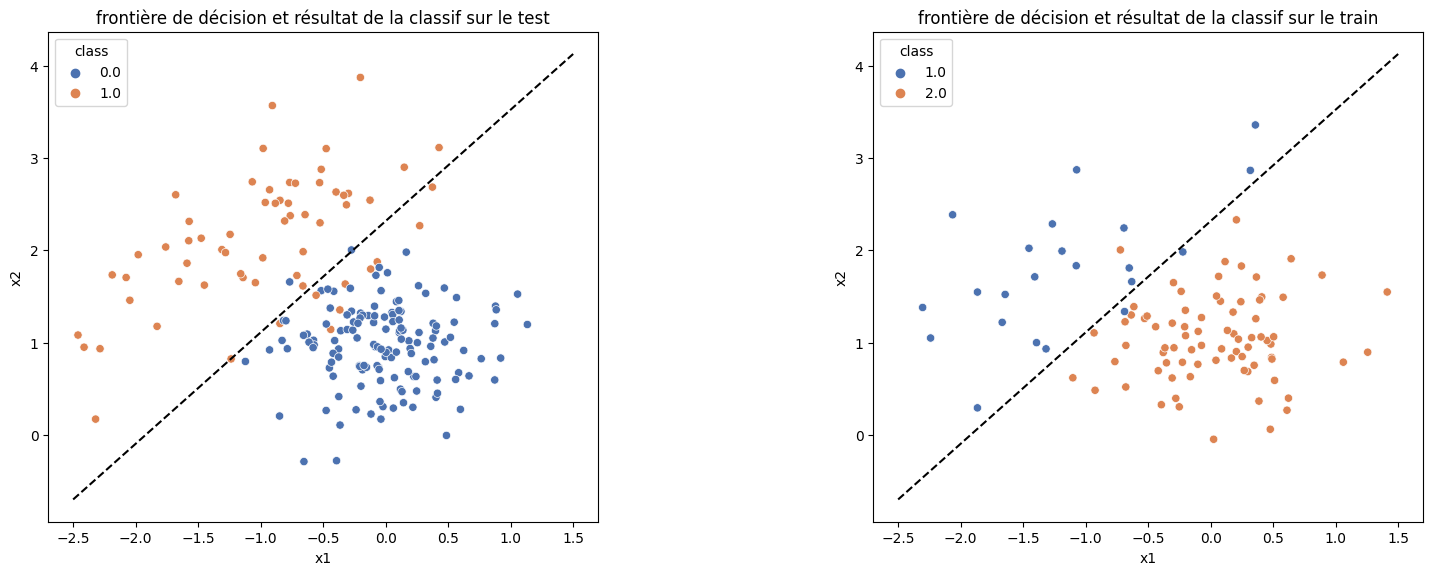

In [8]:
# First compute w... then: 
x1 = np.linspace(-2.5,1.5,10) 
x2 = (-w[0]-w[1]*x1)/w[2]

plt.figure(1,figsize=(10,7))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1.5,
                          top = 0.9, wspace = 0.5, hspace = 0)

plt.subplot(1,2,1)
plt.plot(x1,x2,'k--')
sns.scatterplot(data=pd_test,x='x1',y='x2',hue='class',palette='deep')
plt.title("frontière de décision et résultat de la classif sur le test")

plt.subplot(1,2,2)
plt.plot(x1,x2,'k--')
sns.scatterplot(data=synth_train_pd,x='x1',y='x2',hue='class',palette='deep')
plt.title("frontière de décision et résultat de la classif sur le train")
plt.show()

**Commentaire :**   
Graphiquement, en traçant la frontière de décision ainsi que les points du train et test set on remarque que:  
-pour les données test, le classifieur trouvé fait un certain nombre d'erreur qu'on a calculé au dessus. On a aussi plus de points que pour le training set et le classifieur trouvé semble correspondre avec ce que l'oeil ferait.  
-sur le train set, notre classifier semble également séparer idéalement les points.

Dans notre problème, l'équation de frontière est décrite par $y= \dfrac{-w_0-w_1 \times x}{w_2}$

In [9]:
#ajout de points au training set loins de la frontière de décision
#fonctions pour générer des points dans des intervales 2D [a,b]x[c,d]

def N_echant_unif_ab(a,b,N):
    return (np.random.rand(N)*(b-a))+a

def N_echant(a,b,c,d,N):
    
    s1=N_echant_unif_ab(a,b,N)
    s2=N_echant_unif_ab(c,d,N)

    return np.column_stack((s1,s2))

Ces 2 fonctions permettent de générer des points dans une région du plan. On les génère en utilisant une loi uniforme. Cest fonctions ont été réalisés dans un autre tp de statistique.

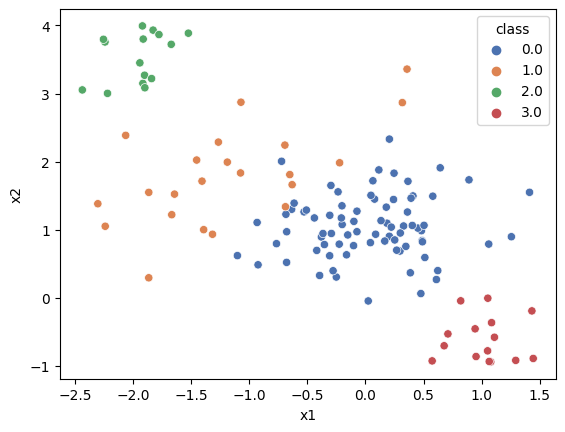

In [10]:
#création et ajout des points au train set. On crée 30 nouveaux points 
X0 =N_echant(-2.5,-1.5,3,4,15)
X1=N_echant(.5,1.5,-1,0,15)
#création des labels
t_0=np.array([1-i//15 for i in range(30)])
#Ces labels sont créés artificillement pour etre utilisés dans le dataframe et etre visualisés d'une couleur différente.
t_1=np.array([2+i//15 for i in range(30)])


X_ajout=np.hstack((np.ones((30,1)),np.vstack((X0,X1))))
data_aug=np.vstack((X,X_ajout))
t_aug=np.hstack((t,t_0))

#to dataframe
data_aug_pd=pd.DataFrame(data_aug,columns=['1','x1','x2'])
data_aug_pd['class']=np.hstack((t,t_1))

#plot des points
sns.scatterplot(data=data_aug_pd, x='x1',y='x2',hue='class', palette='deep')
plt.show()

**Commentaire :** Les points en rouges et verts sont les points ajoutés artificiellement. Ils sont loins de la frontière de décision, voyons comment ils influencent le calcul de la frontière.

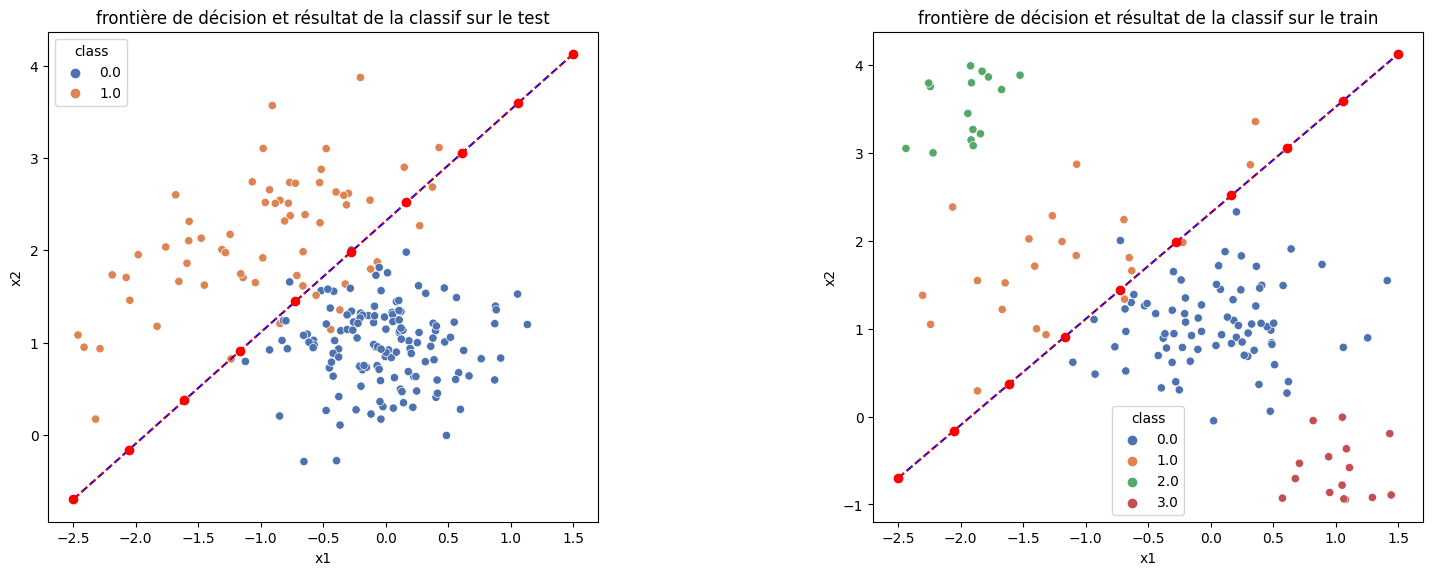

In [11]:
#calcul du nouveau w et observation de l'influence des points loins:
w1, Niter = regression_logistique(data_aug, t_aug, Nitermax=50)
x3 = (-w1[0]-w1[1]*x1)/w1[2]

plt.figure(1,figsize=(10,7))
plt.gcf().subplots_adjust(left = 0.125, bottom = 0.2, right = 1.5,
                          top = 0.9, wspace = 0.5, hspace = 0)

plt.subplot(1,2,1)
plt.plot(x1,x2,'b--')
plt.plot(x1,x3,'r:o')
sns.scatterplot(data=pd_test,x='x1',y='x2',hue='class',palette='deep')
plt.title("frontière de décision et résultat de la classif sur le test")

plt.subplot(1,2,2)
plt.plot(x1,x2,'b--')
plt.plot(x1,x3,'r:o')
sns.scatterplot(data=data_aug_pd,x='x1',y='x2',hue='class',palette='deep')
plt.title("frontière de décision et résultat de la classif sur le train")
plt.show()

**Commentaire :** On remarque bien ici ce qui fait la force de la régression logistique: son insensibilité aux valeurs extrèmes. Si on est loin de 0 pour $w^T\tilde{x}$ alors le classifier n'aura aucun mal à classer le point. Dans cette régression les points facile à classer n'influent pas le modèle. Le graphique au-dessus illustre bien celà avec la droite avec les points rouge qui correspond à la nouvelle frontière et celle en pointillés bmeu qui correspond à la frontière calculée avant. 

## 2. Application: handwritten digits recognition 5 & 6
We load 2 matrices which contain each a sequence of examples of 16x16 images 
of handwritten digits which are 5 and 6 here. Each line of the matrix
contains 256 pixel values coding for the gray level of a 16x16 image.

In [12]:
train_5 = np.loadtxt('train_5.txt',delimiter=',')   # 556 samples
train_6 = np.loadtxt('train_6.txt',delimiter=',')   # 664 samples

### Examples of images


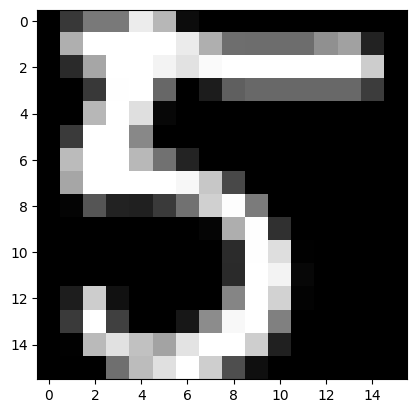

In [13]:
# Digit 5
n=9;
I = np.reshape(train_5[n,:],(16,16))

plt.imshow(I,cmap='gray')
plt.show()

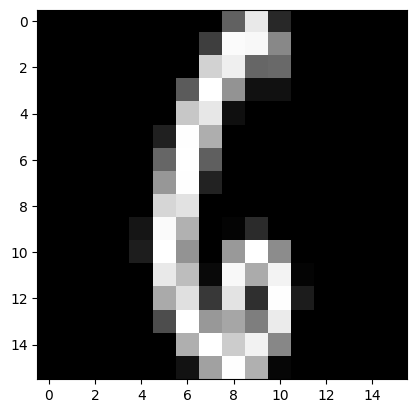

In [14]:
# Digit 6
n=5;
I = reshape(train_6[n,:],(16,16))

plt.imshow(I,cmap='gray')
plt.show()

### Separating the training and test sets

We keep in the training set the 145 first images of 5s and the 200 first
images of 6s:


In [15]:
x_train_brut = np.vstack((train_5[:145,:], train_6[:200,:]))
N_train = np.size(x_train_brut,axis=0)
class_train = np.ones(345)   # label 1 for digit 6
class_train[:145] = 0       # label 0 for digit 5


x_test_brut = np.vstack((train_5[145:,:], train_6[200:,:]))
N_test = np.size(train_5,axis=0)+np.size(train_6,axis=0)-N_train
class_test =np.ones(N_test)
class_test[:np.size(train_5,axis=0)-145]=0

## Exercise 2: logistic regression to classify 5 & 6

1. Note that pixel values are between -1 and 1 by using the functions
 `min(I(:))` and `max(I(:))`.
2. Identify the indices of the most significant pixels, which are defined 
as having a standard deviation greater than 0.5 here. We denote by `lis_sig`
the list of positions of these significant pixels in the image vector.
_Indication : the function `std` gives the standard deviation (columnwise
in matrices) and you should find 173 pixel positions.
3. Show a binary image to locate these pixels.
_Indication : `Isig = zeros(16); Isig(list_sig)=1; Isig=Isig';`._
4. Define the training set `x_train` from `x_train_brut` from the significant pixels only.
5. Do the same with `x_test_brut` to extract `x_test`.
6. Use `regression_logistique.m` to estimate the logistic regression vector
`w` from the training set `x_train`. 
Choose `Nitermax = 13; eps_conv = 1e-3;`
7. Compute the decision function and the labels of the test set `x_test`. 
_Indication : do not forget the column of ones !_
8. Estimate the classification error rate by using :
`erreur = sum(abs(class-class_test))/N_test;`.
9. Locate some misclassified examples and visualize the corresponding image.
Comment on your results and observations.


In [16]:
# Exercise 2
print(f"Question 1: Les valeurs des pixels sont entre {np.min(I[:])} et  {np.max(I[:])}")

Question 1: Les valeurs des pixels sont entre -1.0 et  1.0


In [17]:
#Calcul de la déviation standart pour récupérer les indices des pixels sign du dataset
std_dev = np.std(x_train_brut, axis=0)
significant_indices = np.where(std_dev > 0.5)[0]
lis_sig = significant_indices.tolist()

print(f"il y a {len(lis_sig)} indices avec des pixels significatifs")

il y a 173 indices avec des pixels significatifs


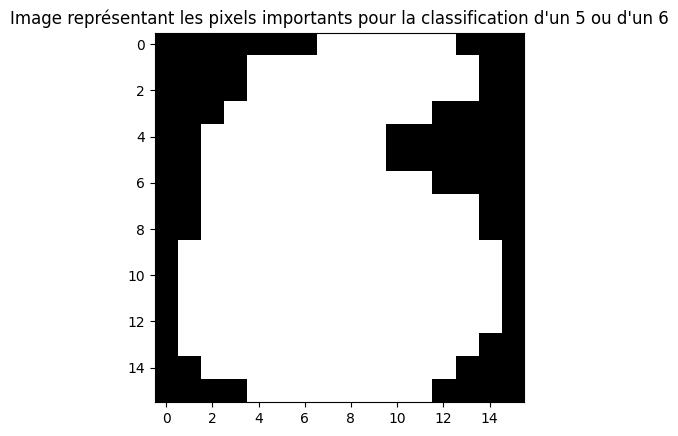

In [18]:
# Show a binary image to locate these pixels.
Isig=zeros(256)
Isig[lis_sig]=1
Isig1 = reshape(Isig,(16,16))

plt.imshow(Isig1,cmap='gray')
plt.title("Image représentant les pixels importants pour la classification d'un 5 ou d'un 6")
plt.show()

**Commentaire :**  
Pour mettre en évidence les pixels importants dans la classification d'un 5 ou d'un 6, on a calculé la déviation standart $ \sigma $ de chaque pixels dans le train set (la distribution étant la liste des pixels situé à un même endroit dans l'image). On a trouvé 173 pixels significatifs. Pour les visualiser on les a situé en blanc dans une image de la même taille que les images de la base de données. Cette image à une forme de 6, qui en surface inclu un 5. Cette image retranscrit bien la forme des chiffres à clssifier donc nous pouvons dire que le seuil $ \sigma $ <0.5 est un bon seuil pour identifier ses pixels. Nous les utiliserons dans la suite de cette partie. Cette identification permet de résuire le nombre de features sur lequel entrainer le modèle et de se concentrer sur ce qui est vraiment important.

**Comment** Pour définir notre nouveau training set. On va prendre en compte uniquement les pixels significatifs et y ajouter une colonne de 1 pour entrainer notre modèle sans tenir compte du biais.

In [19]:
#Nouveau trainset
X_train=x_train_brut[:,lis_sig]
X_train_tild=hstack((np.ones((N_train,1)),X_train))

X_test_2=x_test_brut[:,lis_sig]
X_test_tild=hstack((np.ones((N_test,1)),X_test_2))

In [20]:
#Calcul des paramètres du modèle:
w, Niter= regression_logistique(X_train_tild,class_train,Nitermax=13)

In [21]:
clf=[decision_function(X,w) for X in X_test_tild]
erreur = sum(abs(clf-class_test))/N_test
print(f"L'erreur de classifiaction sur le testset est de : {round(erreur,3)*100}%")


L'erreur de classifiaction sur le testset est de : 7.9%


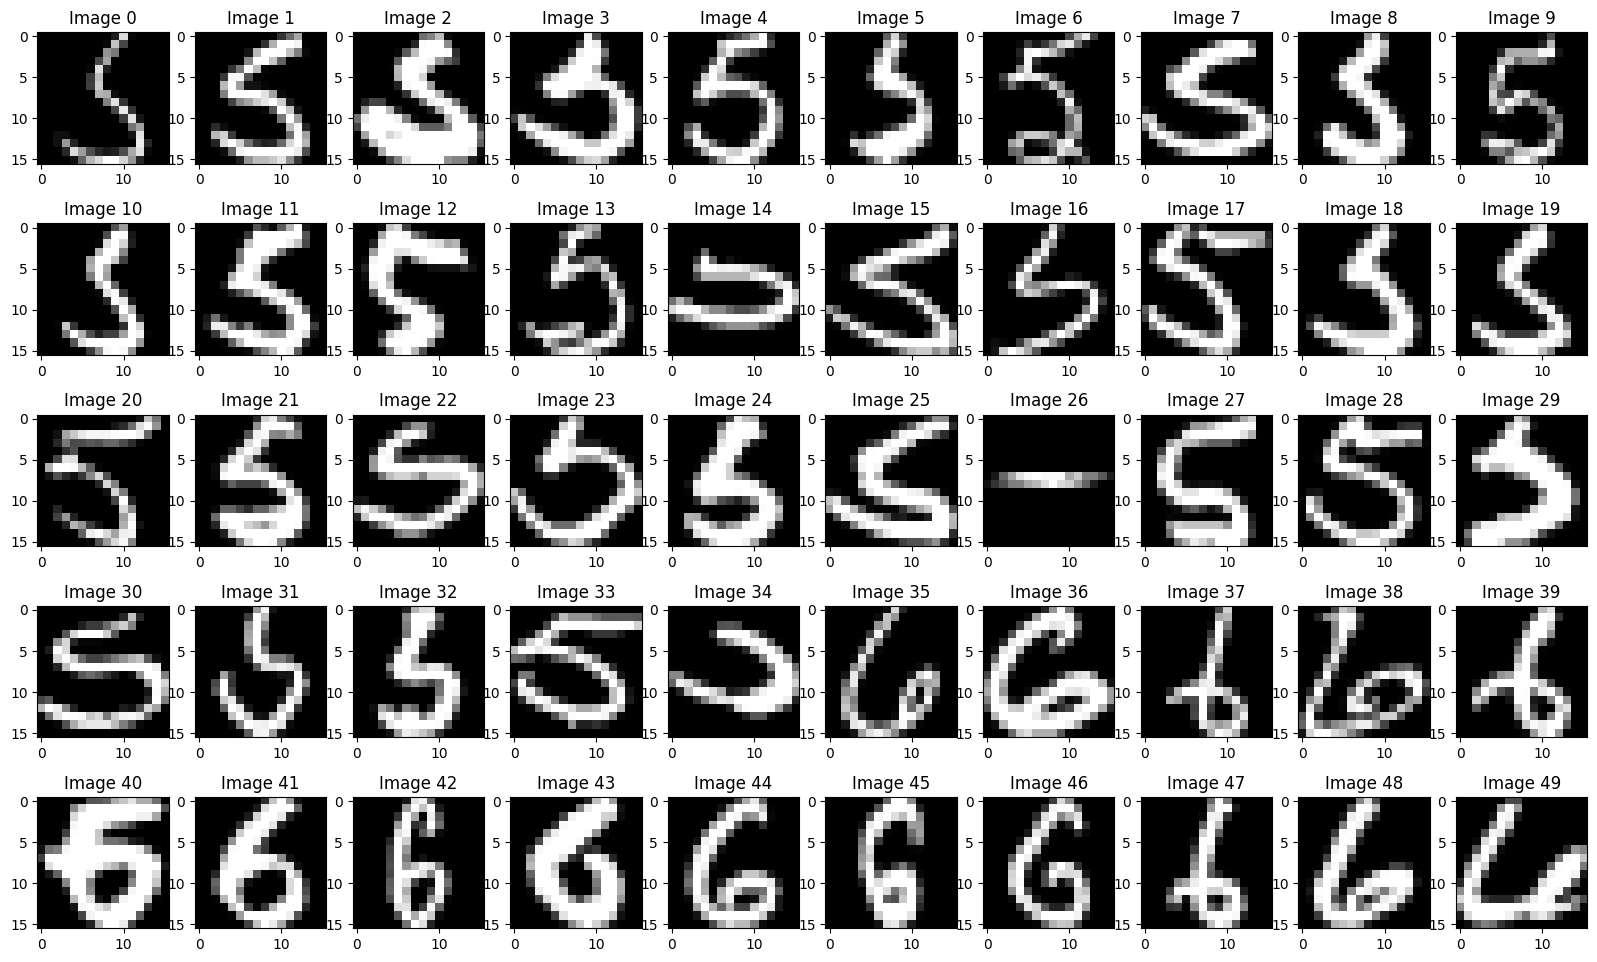

In [22]:
#affichage des digits mal classés
miscl=[x_test_brut[i] for i in range(len(x_test_brut))  if clf[i]!=class_test[i] ]
to_plt=miscl[10:60]
_,ax= plt.subplots(5,10,figsize=(20,12))
for i in range(5):
    for j in range(10):
        ax[i][j].imshow(reshape(to_plt[10*i+j],(16,16)),cmap='gray')
        ax[i][j].set_title(f"Image {10*i+j}")

**Commentaire :** On remarque que pour la plupart des images males classifiées les chiffres dessinés ne sont soit pas fermé ou pas bien écrits (image 46,41,42,11,13,34) ce qui rend la classification compliquée. L'erreur de classification est de près de 8% ce qui est raisonnable. En utilisant plus d'images dans le training set on obtiendrait de meilleurs résultats mais on puourrait aussi risquer d'overfitter le modèle. 

## 3. Logistic regression using `scikit-learn`

1. **Go to** http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html for a presentation of the logistic regression model in `scikit-learn`.

2. **Apply** it to the present data set.

3. **Comment** on the use of logistic regression.

*Indication : you may have a look at* 

a) Theory : http://openclassroom.stanford.edu/MainFolder/DocumentPage.php?course=MachineLearning&doc=exercises/ex5/ex5.html

b) Video :  https://kr.coursera.org/lecture/machine-learning/regularized-logistic-regression-cAxpF 

c) Example : http://scikit-learn.org/stable/auto_examples/exercises/plot_digits_classification_exercise.html#sphx-glr-auto-examples-exercises-plot-digits-classification-exercise-py

*for a short presentation of regularized logistic regression.*

### Partie 1 : données brutes

In [23]:
clf = LogisticRegression(random_state=0).fit(x_train_brut,class_train )
clf.score(x_test_brut,class_test)

0.9725714285714285

In [24]:
pred=clf.predict(x_test_brut)
erreur_reg = round(sum(abs(pred-class_test))/N_test,3)*100
erreurtrain = sum(abs(clf.predict(x_train_brut)-class_train))/N_train

print(f"l'erreur de classification sur le testset est de : {erreur_reg}%")
print(f"l'erreur de classification sur le train set est de : {round(erreurtrain,3)*100}%")

l'erreur de classification sur le testset est de : 2.7%
l'erreur de classification sur le train set est de : 0.0%


**Remarque :** notre erreur correspond bien à 1 moins le score du classifieur.

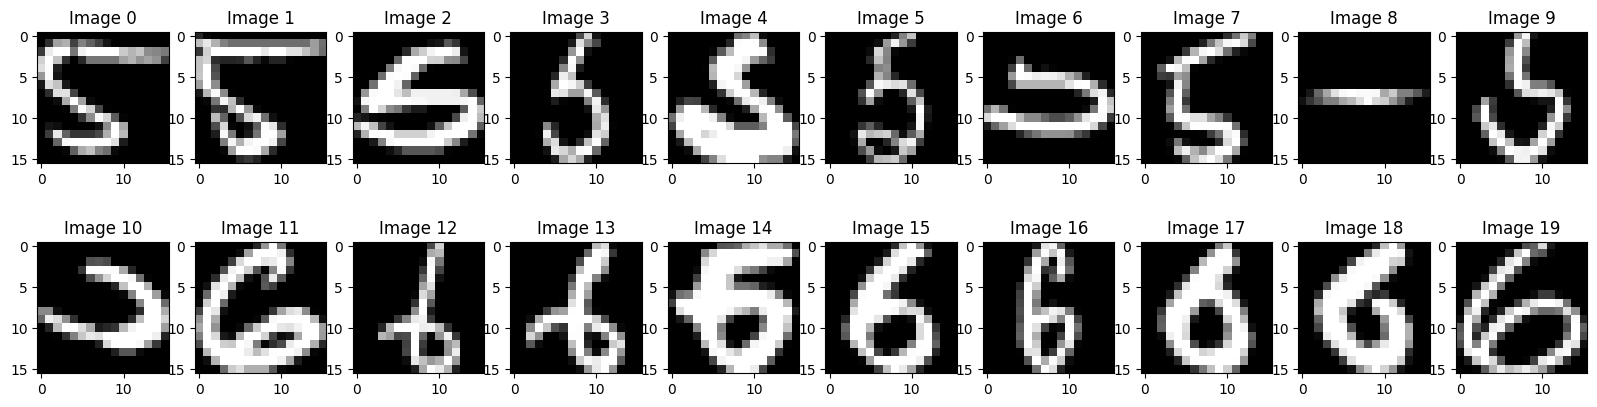

In [25]:
miscl=[x_test_brut[i] for i in range(len(x_test_brut))  if pred[i]!=class_test[i] ]
_,ax= plt.subplots(len(miscl)//10,10,figsize=(20,5))
for i in range(len(miscl)//10):
    for j in range(10):
        ax[i][j].imshow(reshape(miscl[10*i+j],(16,16)),cmap='gray')
        ax[i][j].set_title(f"Image {10*i+j}")

**Commentaire :**  
En utilisant la bibliothèque sklearn pour faire de la régression logistique, on constate que l'erreur de classification sur le testset diminue par rapport à  notre implémentation de la logregression. Cela est dû à la régularisation. En effet utiliser sklearn.linear_model.LogisticRegression sans spécifier de paramètre `penalty` applique par défaut un terme de pénalité avec la loss l2. Dans notre cas, il peut être pertinent de régulariser le modèle parce que compte tenu du faible nombre de données et du grand nombre de paramères, on a de grandes chances de faire de l'overfitting. Voyons ce qu'aurait donné une régression logistique avec sk_learn sans utiliser de régularisation.

In [26]:
clf = LogisticRegression(random_state=0,penalty=None).fit(x_train_brut,class_train )
pred=clf.predict(x_test_brut)
erreur=round(sum(abs(pred-class_test))/N_test,3)*100

print(f"l'erreur de classification sur le testset sans pénalisation est de : {erreur}%")


l'erreur de classification sur le testset sans pénalisation est de : 3.2%


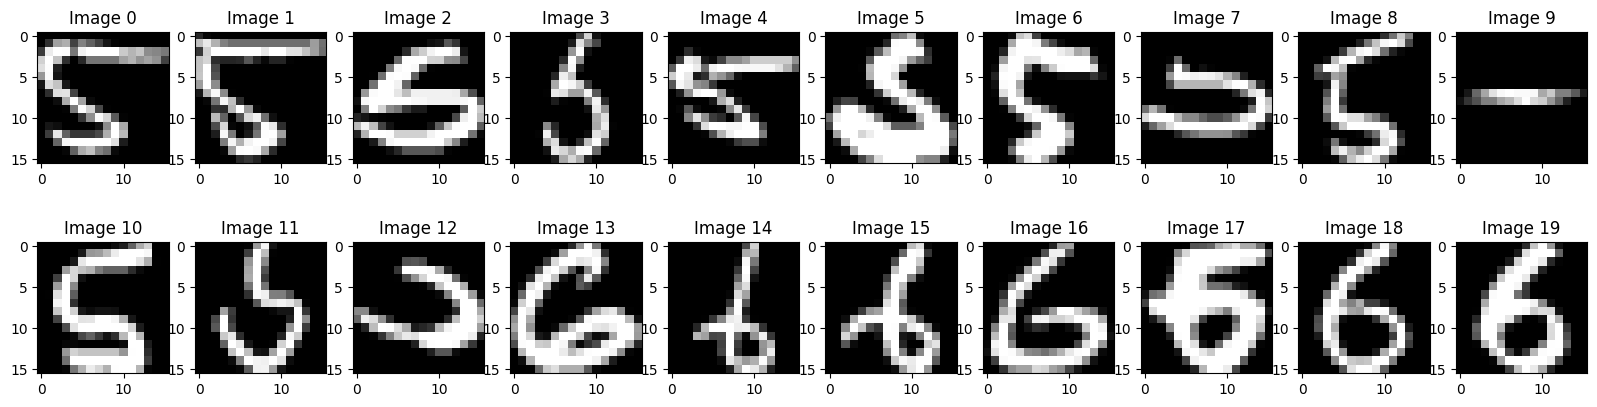

In [27]:

miscl=[x_test_brut[i] for i in range(len(x_test_brut))  if pred[i]!=class_test[i] ]
_,ax= plt.subplots(len(miscl)//10,10,figsize=(20,5))
for i in range(len(miscl)//10):
    for j in range(10):
        ax[i][j].imshow(reshape(miscl[10*i+j],(16,16)),cmap='gray')
        ax[i][j].set_title(f"Image {10*i+j}")

**Commentaire :**  
On remarque ici l'effet de la régularisation. Elle permet d'avoir un meilleure classification sur le test set puisqu'elle pénalise les gros coéficiants. Sans pénalisation (`penalty = None`) on augmente notre erreur de classification de notre problème.

### Partie 2: données avec $\sigma > 0.5$

In [28]:
clf2 = LogisticRegression(random_state=0,penalty=None).fit(X_train,class_train )
err2=round((1-clf2.score(X_test_2,class_test))*100,2)
print(f"l'erreur de classification sur le testset des features significatives est de :{err2} %")

l'erreur de classification sur le testset des features significatives est de :2.97 %


In [29]:
clf2_reg = LogisticRegression(random_state=0).fit(X_train,class_train )
err2_reg=round((1-clf2_reg.score(X_test_2,class_test))*100,2)
print(f"l'erreur de classification sur le testset des features significatives est de :{err2_reg} %")

l'erreur de classification sur le testset des features significatives est de :2.63 %


In [30]:
brut=[erreur,erreur_reg]
red_feat=[err2,err2_reg]
err=pd.DataFrame({'erreur données brutes (%)':brut,'erreur données significatives (%)':red_feat}, index=['sans régularisation','avec régularisation'])
print(f'Récapitulatif des résultats: \n')
err

Récapitulatif des résultats: 



erreur données brutes (%)  \
sans régularisation                        3.2   
avec régularisation                        2.7   

                     erreur données significatives (%)  
sans régularisation                               2.97  
avec régularisation                               2.63

**Synthèse :**
Ce tableau récapitule les résultats trouvés. On remaque 2 choses importantes et attendues:  
-lorsqu'on pénalise notre modèle, on lui emèche d'être trop sensible à certain paramètres donc on diminue sa variance et la conséquence sur le test set est que l'erreur diminue.
-lorsqu'on travaille sur des données qu'on a identifié comme importantes ou significatives, on concentre les efforts sur un certins nombre de critère ce qui est moins couteux en ressource mais surtout ça permet au modèle de réduire aussi son erreur en étant insensible à des features qui ne sont pas pertinentes.

Enfin, compte tenu du solveur qu'utilise sk_learn, on trouve de meilleurs résultats que celui implémenté par la méthode de Newton Raphson en début de TP.